# Zillow Tax Assessed Values

# Goal 

- To create a model capable of predicting future Tax Assessed Values by at least 50%
- To explore the data
- To create a model better than baseline

# Imports

In [1]:
import pandas as pd
import numpy as np
import env
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LassoLars
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import TweedieRegressor
import wrangle
import warnings
warnings.filterwarnings("ignore")
import scipy.stats as stats

# Acquire
- Data acquiured from SQL database
- it contained 53031 rows and 6 columns
- Each row represents a single family home
- Each column represents a catagory of data

# Prepare
- checked that the column datatypes were appropriate
- droped the unnamed: 0 column
- created a boolean mask to find calculated square feet values under 25000
- cut the top 5% of taxvaluedollar count
- dropped the na values
- converted calculatedfinishedsquarefeet, fips and yearbuilt to int's
- Split data into train, validate and test (approx. 60/20/20)

In [2]:
# getting my data and dropping the fips row
df = pd.read_csv('zillow_data.csv')
df = wrangle.preparing_data_zillow(df)
df = df.drop(columns ='fips')

In [3]:
# split my data into train , validate, test
train, validate, test = wrangle.split_data(df, 'taxvaluedollarcnt')

In [4]:
# split my data into different catagories
X_train, X_validate, X_test, y_train, y_validate, y_test = wrangle.get_X_train_val_test(train, validate, test,'taxvaluedollarcnt', 'taxvaluedollarcnt' )

# A brief look at the data

In [5]:
# looking at the training data
train.head()

,taxvaluedollarcnt,calculatedfinishedsquarefeet,bedroomcnt,bathroomcnt,yearbuilt
32389,840605.0,3906,3.0,3.0,1992
18606,600000.0,1480,4.0,3.0,1985
42069,305060.0,1644,4.0,2.0,1962
43726,348094.0,900,3.0,1.0,1953
52530,297838.0,1338,3.0,3.0,1977


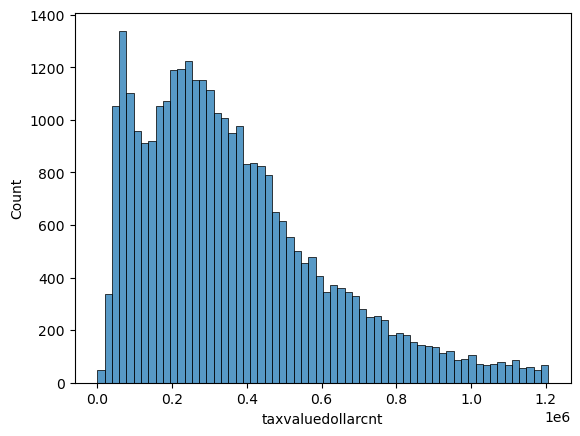

In [26]:
# created a histplot to visualize the target variable
sns.histplot(train.taxvaluedollarcnt)
plt.show()

# A summary of the data

In [6]:
# describing the training data
train.describe()

,taxvaluedollarcnt,calculatedfinishedsquarefeet,bedroomcnt,bathroomcnt,yearbuilt
count,3.181500e+04,31815.000000,31815.000000,31815.000000,31815.000000
mean,3.634415e+05,1753.039887,3.251485,2.144067,1960.357410
std,2.450244e+05,715.738889,0.899468,0.834273,21.388712
min,9.000000e+00,160.000000,0.000000,0.000000,1862.000000
25%,1.795775e+05,1244.000000,3.000000,2.000000,1949.000000
50%,3.130060e+05,1592.000000,3.000000,2.000000,1958.000000
75%,4.906805e+05,2112.500000,4.000000,3.000000,1974.000000
max,1.206527e+06,7648.000000,9.000000,8.000000,2016.000000


# Does Tax-value-dollar-count increase over time

In [7]:
# cut year built into bins and updated the values for readability
BIN_1949_1958, BIN_1861_1949, BIN_1958_1974, BIN_1974_2016, train = wrangle.over_time(train)

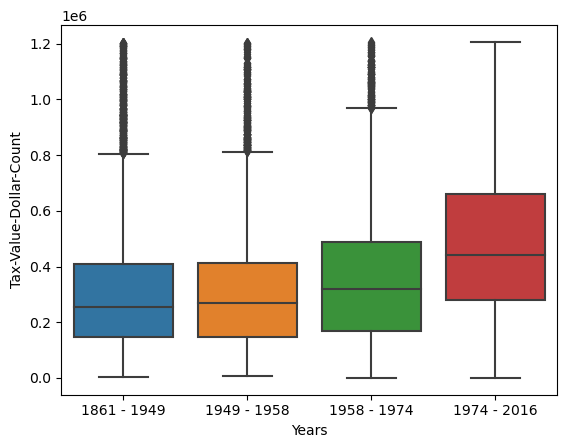

In [8]:
# creating a boxplot to visualize the data
sns.boxplot(train, x= train['year_bins'], y =train['taxvaluedollarcnt'], order = ['1861 - 1949','1949 - 1958','1958 - 1974','1974 - 2016']).set(xlabel ='Years', ylabel ='Tax-Value-Dollar-Count')
plt.show()

- The average of tax value dollar count has went up over the years

<br>
- we assume a normal distribution because of the amount of samples being over 500
<br>
<b>I will now use an anova test to investigate if tax value dollar count has went up over the years.</b>
<br>
- I will use a confidence interval of 95%
- the resulting alpha is .05

<b>Ho: The mean of tax value dollar count has not changed over the years</b>

<b>Ha: The mean of tax value dollar count has changed over the years</b>

In [9]:
# ran and anova stats test
t, p = stats.f_oneway(BIN_1949_1958.taxvaluedollarcnt, BIN_1861_1949.taxvaluedollarcnt,BIN_1958_1974.taxvaluedollarcnt, BIN_1974_2016.taxvaluedollarcnt)
print('we reject the null hypothesis because', p, '< alpha')

we reject the null hypothesis because 0.0 < alpha


# Does number of bedrooms affect tax value dollar count

In [10]:
# cut bedroomcnt into bins and updated the values for readability
BIN_0_2_5, BIN_45675, BIN_22545, BIN_679, train = wrangle.bedrooms_bins(train)

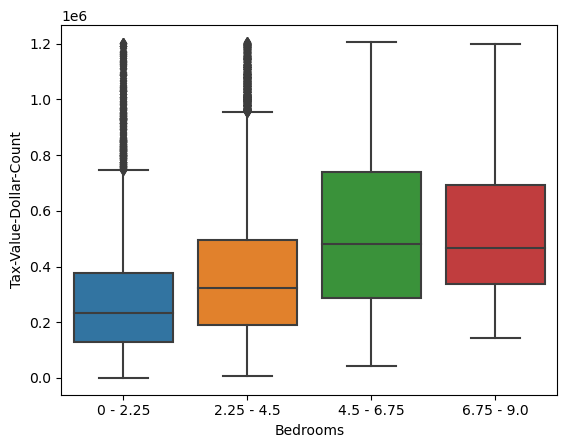

In [11]:
# creating a boxplot to visualize the data
sns.boxplot(train, x= train['bedroom_bins'], y =train['taxvaluedollarcnt'], order = ['0 - 2.25','2.25 - 4.5','4.5 - 6.75','6.75 - 9.0']).set(xlabel ='Bedrooms', ylabel ='Tax-Value-Dollar-Count')
plt.show()

- The average of tax value dollar count is higher the more bedrooms a home posseses

<br>
- we assume a normal distribution because of the amount of samples being over 500
<br>
<b>I will now use an anova test to investigate if tax value dollar count is higher based on bathrooms.</b>
<br>
- I will use a confidence interval of 95%
- the resulting alpha is .05

<b>Ho: The mean of tax value dollar count is the same no matter how many bedrooms a home posseses</b>

<b>Ha: The mean of tax value dollar count is different based on number of bedrooms</b>

In [12]:
# ran an anova stats test
t, p = stats.f_oneway(BIN_0_2_5.taxvaluedollarcnt, BIN_22545.taxvaluedollarcnt, BIN_45675.taxvaluedollarcnt, BIN_679.taxvaluedollarcnt)
print('we reject the null hypothesis because', p, '< alpha')

we reject the null hypothesis because 0.0 < alpha


# Does the Square Feet of the house affect the tax value dollar count

In [13]:
# cut Square Feet into bins and updated the values for readability
size_19999_1242, size_1242_1592, size_1592_2117, size_2117_9200, train = wrangle.square_feet_bins(train)

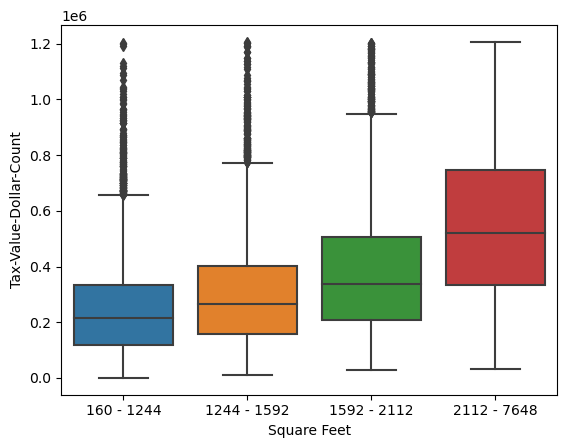

In [14]:
# creating a boxplot to visualize the data
sns.boxplot(train, x= train['size_bins'], y =train['taxvaluedollarcnt'], order = ['160 - 1244','1244 - 1592','1592 - 2112','2112 - 7648']).set(xlabel ='Square Feet', ylabel ='Tax-Value-Dollar-Count')
plt.show()

- The average of tax value dollar count is higher the more square feet a home posseses

<br>
- we assume a normal distribution because of the amount of samples being over 500
<br>
<b>I will now use an anova test to investigate if tax value dollar count is higher based on squarefeet of the home.</b>
<br>
- I will use a confidence interval of 95%
- the resulting alpha is .05

<b>Ho: The mean of tax value dollar count is the same no matter how many square feet a home posseses</b>

<b>Ha: The mean of tax value dollar count is different based on the size of the house</b>

In [15]:
# ran an anova stats test
t, p = stats.f_oneway(size_19999_1242.taxvaluedollarcnt, size_1242_1592.taxvaluedollarcnt, size_1592_2117.taxvaluedollarcnt, size_2117_9200.taxvaluedollarcnt)
print('we reject the null hypothesis because', p, '< alpha')

we reject the null hypothesis because 0.0 < alpha


# Does bathroom count affect the taxvalue dollar count of a home

In [17]:
# cut bathroom count into bins and updated the values for readability
bath_0_2, bath_2_4, bath_4_6, bath_6_8, train = wrangle.bathroom_bins(train)

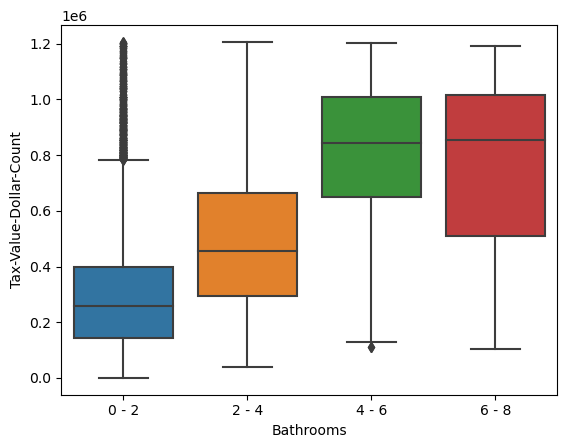

In [18]:
# creating a boxplot to visualize the data
sns.boxplot(train, x= train['bathroom_bins'], y =train['taxvaluedollarcnt'], order = ['0 - 2','2 - 4','4 - 6','6 - 8']).set(xlabel ='Bathrooms', ylabel ='Tax-Value-Dollar-Count')
plt.show()

- The average of tax value dollar count is higher the more bathrooms a home posseses

<br>
- we assume a normal distribution because of the amount of samples being over 500
<br>
<b>I will now use an anova test to investigate if tax value dollar count is higher based on number of bathrooms in a home.</b>
<br>
- I will use a confidence interval of 95%
- the resulting alpha is .05

<b>Ho: The mean of tax value dollar count is the same no matter how many bathrooms a home posseses</b>

<b>Ha: The mean of tax value dollar count is different based on number of bathrooms in a home</b>

In [19]:
# ran an anova stats test
t, p = stats.f_oneway(bath_0_2.taxvaluedollarcnt, bath_2_4.taxvaluedollarcnt, bath_4_6.taxvaluedollarcnt, bath_6_8.taxvaluedollarcnt)
print('we reject the null hypothesis because', p, '< alpha')

we reject the null hypothesis because 0.0 < alpha


## Exploratory Summary

<b>Tax Value Dollar Count was affected by</b>
- Calculated square feet 
- Bathroom count
- Bedroom count
- Year built

## Features I am moving to modeling With

- Calculated square feet 
- Bathroom count
- Bedroom count
- Year built

## Modeling

- I will be scaling my data with a robust scaler

** I will be evaluating models developed using four different model types and various hyperparameter configurations * Models will be evaluated on train and validate data * The model that performs the best will then be evaluated on test data

In [20]:
# scaled my data
X_train_scaled, X_validate_scaled, X_test_scaled= wrangle.scaled_data_to_dataframe(X_train, X_validate, X_test)

In [21]:
# ran my data through the different model types
metrics_train_df, metrics_validate_df, metrics_test_df = wrangle.get_model_numbers(X_train_scaled, X_validate_scaled, X_test_scaled, y_train, y_validate, y_test)

In [22]:
#showing the results from the models
metrics_train_df

,model_train,rmse,r2
0,baseline,245020,0
1,ordinary least squared(OLS),206111,29
2,lasso lars(lars),206111,29
3,Polynomial Regression(poly2),204664,30
4,Generalized Linear Model (GLM),210360,26


In [23]:
#showing the results from the models
metrics_validate_df

,model_validate,rmse,r2
0,baseline,245020,0
1,ordinary least squared(OLS),204155,29
2,lasso lars(lars),204155,29
3,Polynomial Regression(poly2),202460,31
4,Generalized Linear Model (GLM),218487,19


In [24]:
#showing the results from the models
metrics_test_df

,model_validate,rmse,r2
0,baseline,245020,0
1,Polynomial Regression(poly2),201313,30


# Conclusions

## explore recap
- calculated finished square feet affect tax value dollar count
- bathroom count affect tax value dollar count
- bedroom count affect tax value dollar count
- year built affect tax value dollar count
    - The average of tax value dollar count has went up over the years
    - The average of tax value dollar count is higher the more bedrooms a home posseses
    - The average of tax value dollar count is higher the more square feet a home posseses
    - The average of tax value dollar count is higher the more bathrooms a home posseses


## Modeling Summary
- Polynomial Regression performed best
    - rmse of 202664 
    - r2 score of 31
- lasso lars and ordinary least squared performed second best
    - rmse scores of 206111
    - r2 scores of 29
- Generalized Linear Model performed worst at
    - 218487 rmse
    - 26 r2 score

## Solution

- Since the top model only performed 31% at best we cannot move forward with it
- The solution would be to continue onto next steps in hopes of creating a better model

# next steps

- look for more things that affect tax value dollar count
- break the catagories up by location subcatagories
- imput new columns of information into the modeling tests